In [42]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from src.Transformer.DecoderOnly import PointSimplexDecoderOnlyTransformer
from src.Datasets.SyntheticDataset import SimplePeriodicDataset
from src.Transformer.DistanceMetrics import euclidean, manhattan, cosine, infinity_norm
from torch.utils.data import DataLoader, random_split

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Variables
len_timeseries = 512
seq_len = 48
batch_size = 64

dataset = SimplePeriodicDataset(len_timeseries=len_timeseries, seq_len=seq_len, shift=1)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size

train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

# === Model ===
model = PointSimplexDecoderOnlyTransformer(
    d_in=dataset[0][0].shape[-1] + dataset[0][1].shape[-1],
    d_out=dataset[0][0].shape[-1],
    emb_size=128,
    ffn_n_hidden=128,
    num_layers=3,
    norm_first=True,
    distance_metric=euclidean,
    conv_out_dim=64,
    kernel_size=7,
    n_heads=4
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses = []

for epoch in range(120):
    # --- Training ---
    model.train()
    train_loss = 0.0
    for X_src, fX_src, _, fX_tgt in train_loader:
        X_src, fX_src, fX_tgt = X_src.to(device), fX_src.to(device), fX_tgt.to(device)

        # Create causal mask
        mask = torch.tril(torch.ones((seq_len, seq_len), device=device)).unsqueeze(0).repeat(X_src.size(0), 1, 1) # (batch_size, seq_len, seq_len)

        preds = model(X_src, fX_src, mask=mask)
        target = fX_tgt[..., 0].unsqueeze(-1)

        loss = criterion(preds, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_src, fX_src, _, fX_tgt in val_loader:
            X_src, fX_src, fX_tgt = X_src.to(device), fX_src.to(device), fX_tgt.to(device)

            mask = torch.tril(torch.ones((seq_len, seq_len), device=device)).unsqueeze(0).repeat(X_src.size(0), 1, 1) # (batch_size, seq_len, seq_len)
            preds = model(X_src, fX_src, mask)
            target = fX_tgt[..., 0].unsqueeze(-1)

            loss = criterion(preds, target)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/120 | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")


Using device: cuda
Epoch 1/120 | Train Loss: 69.0714 | Val Loss: 63.7809
Epoch 2/120 | Train Loss: 59.5042 | Val Loss: 53.2575
Epoch 3/120 | Train Loss: 49.2561 | Val Loss: 41.3118
Epoch 4/120 | Train Loss: 34.4704 | Val Loss: 22.4087
Epoch 5/120 | Train Loss: 19.1024 | Val Loss: 24.3958
Epoch 6/120 | Train Loss: 19.2194 | Val Loss: 15.8991
Epoch 7/120 | Train Loss: 17.2319 | Val Loss: 15.8598
Epoch 8/120 | Train Loss: 15.6928 | Val Loss: 17.9447
Epoch 9/120 | Train Loss: 15.3358 | Val Loss: 15.8812
Epoch 10/120 | Train Loss: 15.3077 | Val Loss: 16.8443
Epoch 11/120 | Train Loss: 15.1111 | Val Loss: 15.8049
Epoch 12/120 | Train Loss: 15.1275 | Val Loss: 16.1336
Epoch 13/120 | Train Loss: 14.9619 | Val Loss: 16.0392
Epoch 14/120 | Train Loss: 15.0470 | Val Loss: 15.9528
Epoch 15/120 | Train Loss: 14.9826 | Val Loss: 16.0685
Epoch 16/120 | Train Loss: 14.9762 | Val Loss: 16.0020
Epoch 17/120 | Train Loss: 14.8396 | Val Loss: 16.0124
Epoch 18/120 | Train Loss: 14.9043 | Val Loss: 16.0394


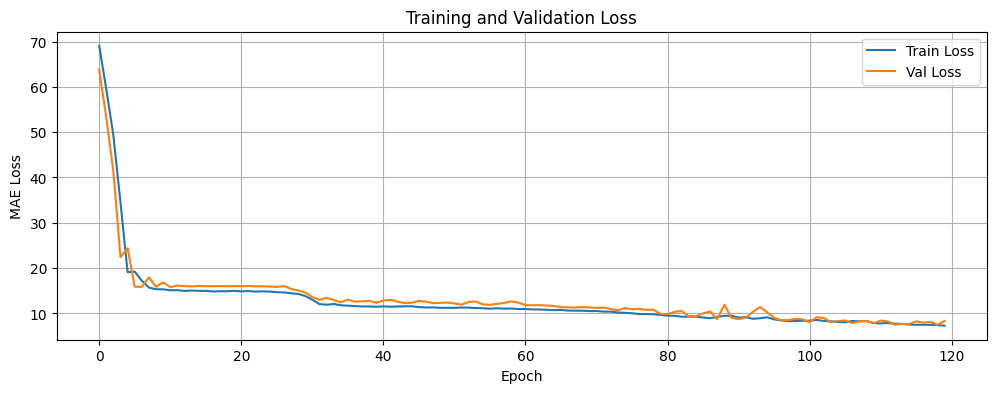

In [44]:
# === Plot Loss ===
plt.figure(figsize=(12, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.legend()
plt.grid()
plt.show()

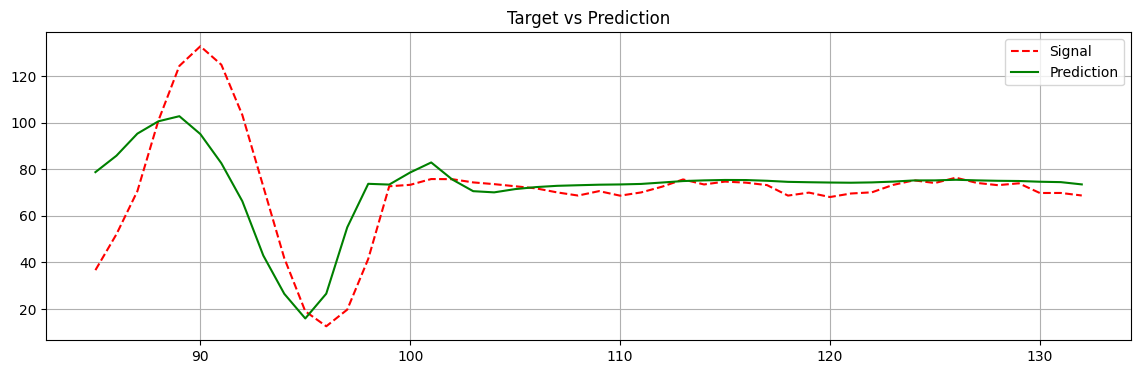

In [45]:
# Retrieve input signal and target
model.eval()
X, fX, _, y = dataset[250]
X = X.unsqueeze(0).cpu()
fX = fX.unsqueeze(0).cpu()
mask = torch.tril(torch.ones(X.shape[1], X.shape[1])).unsqueeze(0).cpu()
model.to('cpu')

with torch.no_grad():
    pred = model(X, fX, mask=mask).squeeze(0).cpu()
    fX = fX.squeeze(0).cpu()

plt.figure(figsize=(14, 4))
start_idx = 85
plt.plot(range(start_idx, start_idx + len(fX)), fX, 'r--', label='Signal')
plt.plot(range(start_idx, start_idx + len(fX)), pred, 'g-', label='Prediction')
plt.legend()
plt.title("Target vs Prediction")
plt.grid()
plt.show()


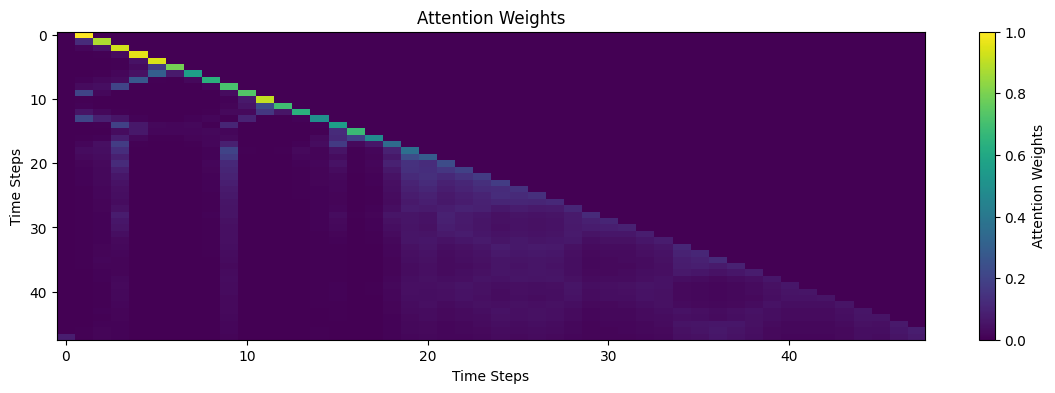

In [46]:
# visualize attention weights in a plot underneath the time series
plt.figure(figsize=(14, 4))
# Aggregate attention weights by averaging across heads
attention_weights = model.transformer_blocks[0].attention.attention_weight.mean(dim=0).squeeze(0).cpu()
plt.imshow(attention_weights, cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Weights')
plt.title("Attention Weights")
plt.xlabel("Time Steps")
plt.ylabel("Time Steps")
plt.show()


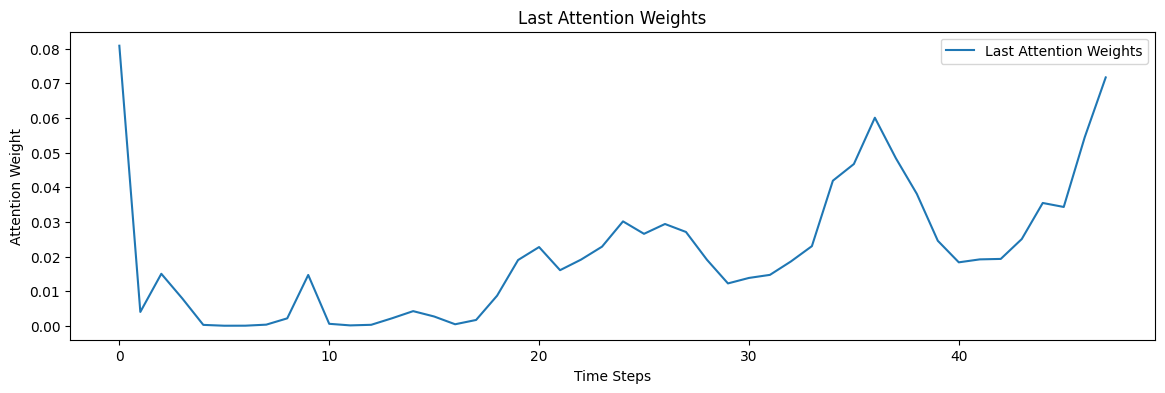

In [47]:
# Plot only last attention weights as line plot
plt.figure(figsize=(14, 4))
plt.plot(attention_weights[-1, :].cpu(), label='Last Attention Weights')
plt.title("Last Attention Weights")
plt.xlabel("Time Steps")
plt.ylabel("Attention Weight")
plt.legend()

# Autoregressive

In [48]:
def autoregressive_forecast(model, X, fX, forecast_horizon, device):
    """
    Autoregressively predict the next `forecast_horizon` steps using the model.
    X: covariates, shape (1, seq_len, cov_dim)
    fX: past features, shape (1, seq_len, feat_dim)
    """
    model.eval()
    X = X.clone().to(device)
    fX = fX.clone().to(device)

    preds = []
    for _ in range(forecast_horizon):
        seq_len = fX.shape[1]
        mask = torch.tril(torch.ones((seq_len, seq_len), device=device)).unsqueeze(0)

        with torch.no_grad():
            pred = model(X, fX, mask=mask)  # (1, seq_len, 1)
            next_val = pred[:, -1:, :]  # Pak laatste voorspelde tijdstap

        # Voeg nieuwe voorspelling toe aan sequentie
        fX = torch.cat([fX, next_val], dim=1)
        X = torch.cat([X, X[:, -1:, :]], dim=1)  # eventueel copy van laatste covariaten of update

        preds.append(next_val.squeeze(0).squeeze(-1).cpu())

    return torch.stack(preds, dim=0)  # shape: (forecast_horizon,)


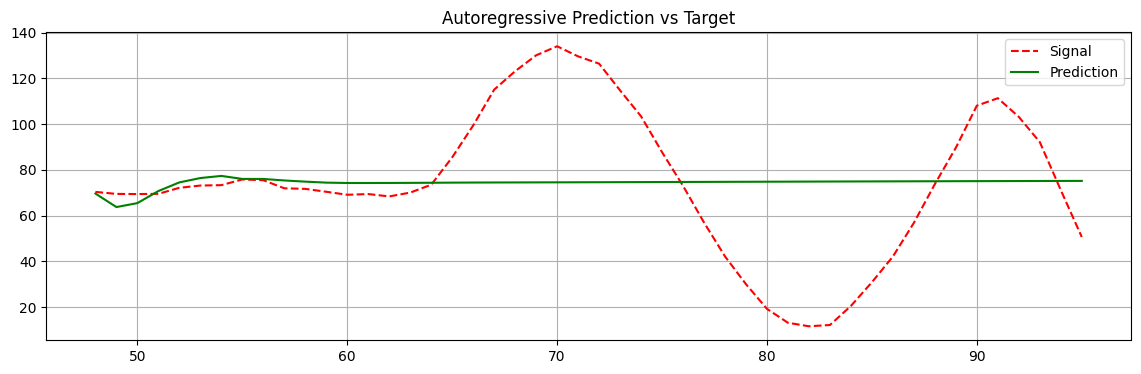

In [49]:
X, fX, _, y = dataset[320]
X = X.unsqueeze(0).to('cpu')
fX = fX.unsqueeze(0).to('cpu')

forecast_horizon = 48  # zelfde lengte als target
forecast = autoregressive_forecast(model, X, fX, forecast_horizon, 'cpu')

plt.figure(figsize=(14, 4))
start_idx = 100
input_signal = fX[0, :, 0].cpu()
target = y.cpu()

plt.plot(range(len(input_signal), len(input_signal) + len(forecast)), input_signal, 'r--', label='Signal')
plt.plot(range(len(input_signal), len(input_signal) + len(forecast)), forecast, 'g-', label='Prediction')
plt.legend()
plt.title("Autoregressive Prediction vs Target")
plt.grid()
plt.show()



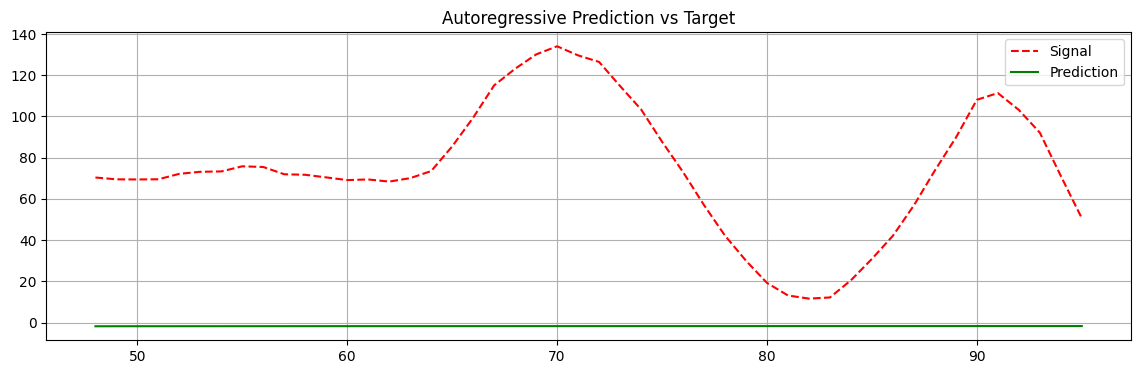

In [50]:
X, fX, _, y = dataset[320]
X = X.unsqueeze(0).to(device)
fX = fX.unsqueeze(0).to(device)

forecast_horizon = 48  # zelfde lengte als target
forecast = autoregressive_forecast(autoregressive_model, X, fX, forecast_horizon, device)

plt.figure(figsize=(14, 4))
start_idx = 100
input_signal = fX[0, :, 0].cpu()
target = y.cpu()

plt.plot(range(len(input_signal), len(input_signal) + len(forecast)), input_signal, 'r--', label='Signal')
plt.plot(range(len(input_signal), len(input_signal) + len(forecast)), forecast, 'g-', label='Prediction')
plt.legend()
plt.title("Autoregressive Prediction vs Target")
plt.grid()
plt.show()